Source: http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

use_cuda = torch.cuda.is_available()

In [2]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    #put a space between punctuation, so not included in word
    s = re.sub(r"([.!?])", r" \1", s)
    #remove things that are not letters or punctuation
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def unicodeToAscii(s):
    # basically removes non-english standard alphabet letters and replaces with equivalent.
    # so no accented letters => less to learn
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def readLangs(input_file_location, lang1_name="English", lang2_name="French"):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(input_file_location, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    input_lang = Lang(lang1_name)
    output_lang = Lang(lang2_name)

    return input_lang, output_lang, pairs

In [3]:
# To make learning easier, we will limit to sentences less than max length 
# in either language
# And only take sentences that start with certain prefixes
# Removed punctuation b/c filtered out in our normalize function

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(input_file_location, lang1_name="English", 
                lang2_name="French"):
    input_lang, output_lang, pairs = readLangs(input_file_location, lang1_name,
                                              lang2_name)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [4]:
#start of sentence
SOS_token = 0
# end of sentence
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2count = {}
        self.n_words = 2
        
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
input_lang, output_lang, pairs = prepareData("../../../data/text/fra-eng/fra.txt")
print(random.choice(pairs))

Reading lines...
Read 149861 sentence pairs
Trimmed to 11589 sentence pairs
Counting words...
Counted words:
English 3016
French 4634
['i m just looking .', 'je ne fais que regarder .']


In [6]:
class EncoderRNN(nn.Module):
    """
    Simple encoder network that embeds the character and then feeds through a GRU
    """
    def __init__(self, input_size, hidden_size, batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, self.batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
class AttnDecoderRNN(nn.Module):
    """
    Attn Decoder
    1. Need max length because learning which input words to attend to
    And thus need to know the maximum number of words could attend to
    2. The attn_weights tell us how much to weight each input word - in this case French,
       In order to predict the english word.
    """
    def __init__(self, input_size, hidden_size, batch_size,
                 dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(hidden_size, hidden_size)
        # note input and output same size
        self.linear = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.attn_layer = nn.Linear(2 * self.hidden_size, MAX_LENGTH)
        self.out_layer = nn.Linear(self.hidden_size, input_size)
        self.attn_combined_layer = nn.Linear(2 * self.hidden_size, self.hidden_size)
    
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        attn = self.attn_layer(torch.cat((embedded[0], hidden[0]),dim=1))
        attn_weights = self.softmax(attn)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs) #shape: bx1xh
        attn_combined = torch.cat((embedded[0], attn_applied[:,0,:]), 1)
        attn_combined = self.relu(self.attn_combined_layer(attn_combined).unsqueeze(0))
        output, hidden = self.gru(attn_combined, hidden)
        output = self.softmax(self.out_layer(output[0]))
        return output, hidden, attn_weights
    
    def initHidden(self):
        result = Variable(torch.zeros(1, self.batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result        

In [7]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer,
         decoder_optimizer, criterion, batch_size, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()
    loss = 0
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
    
    encoder_outputs = Variable(torch.zeros((batch_size, MAX_LENGTH, encoder.hidden_size)))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else decoder_input
    
    # Here we are feeding in the english words to get the final hidden state 
    # for the decoder
    for i in range(input_length):
        encoder_ouput, encoder_hidden = encoder.forward(input_variable[:,i,:], encoder_hidden)
        encoder_outputs[:,i,:] = encoder_ouput[0]
        
    decoder_hidden = encoder_hidden
    decoder_input = Variable(torch.LongTensor([[SOS_token]]*batch_size))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # Here we take the final hidden state from the encoder
    # And feed it to decoder
    # We also give decoder the word to predict the next word starting with SOS token
    # If use teacher forcing then give it the truth, otherwise give it prediction
    if use_teacher_forcing:
        for i in range(target_length):
            decoder_output, decoder_hidden, attn_weights = decoder.forward(decoder_input, 
                                                                           decoder_hidden,
                                                                          encoder_outputs)

            loss += criterion(decoder_output, target_variable[:,i,0])
            decoder_input = target_variable[:,i,:]
            
    else:
        for i in range(target_length):
            decoder_output, decoder_hidden, attn_weights = decoder.forward(decoder_input, 
                                                                           decoder_hidden,
                                                                           encoder_outputs)
            loss += criterion(decoder_output, target_variable[:,i,0])
            topv, topi = decoder_output.data.topk(1)
            decoder_input = Variable(topi)
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [8]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [10]:
def trainIters(encoder, decoder, data_loader, epochs, batch_size, print_every=1000,
               plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()
    iter = 1
    n_iters = len(data_loader) * epochs
    for epoch in range(1, epochs + 1):
        for i_batch, sample_batched in enumerate(data_loader):
            
            loss = train(Variable(sample_batched[0]), Variable(sample_batched[1]), encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion,
                        batch_size)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg))
            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
            iter = iter + 1
            
    showPlot(plot_losses)

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, input_lang, output_lang, max_length):
        self.data = data
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.max_length = max_length

    def __getitem__(self, index):
        row = self.data[index]
        training_pairs = self.tensorFromPair(row)
        return (training_pairs[0], training_pairs[1])
    
    def indexesFromSentence(self, lang, sentence):
        return [lang.word2index[word] for word in sentence.split(" ")]

    def tensorFromSentence(self, lang, sentence):
        indexes = self.indexesFromSentence(lang, sentence)
        indexes.append(EOS_token)
        # make it 1 column with number of rows equal to words in sentence
        result = torch.LongTensor(indexes).view(-1, 1)
        pad_amount = MAX_LENGTH - result.size(0)
        if pad_amount > 0:
            result = F.pad(result, (0,0,0,pad_amount), value=EOS_token).data
        result = result.cuda() if use_cuda else result
        return result

    def tensorFromPair(self, pair):
        input_variable = self.tensorFromSentence(self.input_lang, pair[0])
        output_variable = self.tensorFromSentence(self.output_lang, pair[1])
        return (input_variable, output_variable)
        
    def __len__(self):
        return len(self.data)

batch_size = 256
training_dataset = CustomDataset(pairs, input_lang, output_lang, MAX_LENGTH)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True,
                                drop_last=True)

0m 3s (- 1m 3s) (50 5%) 4.8601
0m 7s (- 0m 59s) (100 11%) 3.6264
0m 11s (- 0m 55s) (150 16%) 3.2359
0m 14s (- 0m 52s) (200 22%) 3.0538
0m 18s (- 0m 48s) (250 27%) 2.8982
0m 22s (- 0m 44s) (300 33%) 2.8073
0m 26s (- 0m 40s) (350 38%) 3.0554
0m 29s (- 0m 37s) (400 44%) 2.7399
0m 33s (- 0m 33s) (450 50%) 2.6641
0m 37s (- 0m 29s) (500 55%) 2.5867
0m 40s (- 0m 25s) (550 61%) 2.5530
0m 44s (- 0m 22s) (600 66%) 2.4828
0m 48s (- 0m 18s) (650 72%) 2.4638
0m 51s (- 0m 14s) (700 77%) 2.4226
0m 55s (- 0m 11s) (750 83%) 2.3918
0m 59s (- 0m 7s) (800 88%) 2.3222
1m 3s (- 0m 3s) (850 94%) 2.3179
1m 6s (- 0m 0s) (900 100%) 2.3016


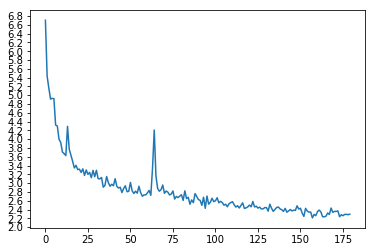

In [16]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size, batch_size)
decoder = AttnDecoderRNN(output_lang.n_words, hidden_size, batch_size)

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    
trainIters(encoder, decoder, training_dataloader, 20, batch_size, print_every=50,
          plot_every=5)

In [ ]:
torch.save(encoder.state_dict(), "../models/attn_encoder.state")
torch.save(decoder.state_dict(), "../models/attn_decoder.state")

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]

    for i in range(input_length):
        encoder_ouput, encoder_hidden = encoder.forward(input_variable[i], encoder_hidden)
        
    decoder_hidden = encoder_hidden
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoded_words = []
    for i in range(MAX_LENGTH):
        decoder_output, decoder_hidden = decoder.forward(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        top_predicted = topi[0][0]

        decoder_input = Variable(torch.LongTensor([[top_predicted]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        if top_predicted == EOS_token:
            decoded_words.append("<EOS>")
            break
        else:
            decoded_words.append(output_lang.index2word[top_predicted])
    return decoded_words

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(">", pair[0])
        print("=", pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        print("<", " ".join(output_words))
        print('')

In [ ]:
evaluateRandomly(encoder, decoder)

In [ ]:
evaluate(encoder, decoder, "i m going to teach .")